# policy gradient method
方策勾配法による迷路の探索。  


分類 : REINFORCEの亜種  
- モデルフリー  
- 方策ベース  
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

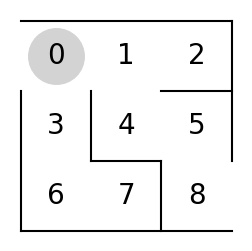

In [2]:
#迷路作成
fig = plt.figure(figsize=(3,3))

#壁
plt.plot([0, 3], [3, 3], color="k")
plt.plot([0, 3], [0, 0], color="k")
plt.plot([0, 0], [0, 2], color="k")
plt.plot([3, 3], [1, 3], color="k")
plt.plot([1, 1], [1, 2], color="k")
plt.plot([2, 3], [2, 2], color="k")
plt.plot([2, 1], [1, 1], color="k")
plt.plot([2, 2], [0, 1], color="k")

#数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha="center", va="center")

#円
circle, = plt.plot([0.5], [2.5], marker="o", color="#d3d3d3", markersize="40")

#メモリと枠の非表示
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", right="off", left="off", labelleft="off")
plt.box("off")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



In [3]:
#パラメータθの初期化 (環境既知という仮定？)
theta_0 = np.array([  #上、右、下、左
    [np.nan, 1, 1, np.nan],      #0
    [np.nan, 1, 1, 1],           #1
    [np.nan, np.nan, np.nan, 1], #2
    [1, np.nan, 1, np.nan],      #3
    [1, 1, np.nan, np.nan],      #4
    [np.nan, np.nan, 1, 1],      #5
    [1, 1, np.nan, np.nan],      #6
    [np.nan, np.nan, np.nan, 1], #7
    [1, 1, np.nan, np.nan],      #8
])

In [4]:
#ソフトマックス方策
def soft_max_policy(theta:np.array, beta=1):
    [s, a] = theta.shape #s, a : 状態、行動の数
    pi = np.zeros((s,a)) 
    exp_theta = np.exp(theta * beta)
    for i in range(0, s):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    pi = np.nan_to_num(pi)
    return pi


In [5]:
pi_0 = soft_max_policy(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.5        0.5        0.         0.        ]]


In [6]:
#行動方策の定義

#ランダム
def get_a_random(pi, s):
    return np.random.choice([0,1,2,3], p=pi[s])

In [7]:
def get_s_next(s, a):
    if a==0:
        return s-3
    elif a==1:
        return s+1
    elif a==2:
        return s+3
    elif a==3:
        return s-1

In [8]:
def play(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    while True:
        a = get_a_random(pi, s)
        s_next = get_s_next(s, a)
        s_a_history[-1][1] = 1
        s_a_history.append([s_next, np.nan])

        if s_next == 8:
            break
        else:
            s = s_next
    return s_a_history

In [9]:
s_a_history = play(pi_0)
print(s_a_history)
print(len(s_a_history) + 1)

[[0, 1], [1, 1], [4, 1], [5, 1], [4, 1], [5, 1], [8, nan]]
8


In [10]:
def updata_theta(theta, pi, s_a_history):
    eta = 0.1
    total = len(s_a_history) - 1
    [s_count, a_count] = theta.shape
    
    delta_theta = theta.copy()
    for i in range(0, s_count):
        for j in range(0, a_count):
            if not(np.isnan(theta[i, j])):
                sa_ij = [sa for sa in s_a_history if sa == [i,j]]
                n_ij = len(sa_ij)
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                n_i = len(sa_i)
                delta_theta[i,j] = (n_ij + pi[i,j] * n_i ) / total
    return theta + eta * delta_theta

In [11]:
def my_updata_theta(theta, pi, s_a_history):
    eta = 0.1
    total = len(s_a_history) - 1
    [s_count, a_count] = theta.shape
    
    delta_theta = theta.copy()
    for i in range(0, s_count):
        for j in range(0, a_count):
            if not(np.isnan(theta[i, j])):
                sa_ij = [sa for sa in s_a_history if sa == [i,j]]
                n_ij = len(sa_ij)
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                n_i = len(sa_i)
                delta_theta[i,j] = (n_ij - pi[i,j] * n_i ) / total
    return theta + eta * delta_theta

In [12]:
def validate_action_policy(s_a_history):
    count = 0
    correct_a = np.array([1, 2, 3, 0, 1, 2, 0, 3, np.nan])
    for sa in s_a_history:
        s, a = sa
        if a == correct_a[s]:
            count += 1
    return count / len(s_a_history)

In [13]:
def learning(theta_0, pi_0, epoch=1000, stop_epsilon=10e-3, updata_theta=updata_theta, beta=1):
    theta = theta_0
    pi = pi_0
    delta = []
    val = []
    total = []
    for episode in range(1000):
        s_a_history = play(pi)
        theta = updata_theta(theta, pi, s_a_history)
        pi_new = soft_max_policy(theta, beta)
        pi_delta = np.sum(np.abs(pi_new - pi))
        pi = pi_new
        # print(f"episode:{episode}, step:{len(s_a_history)-1}, delta_pi:{pi_delta}")
        delta.append(pi_delta)
        val.append(validate_action_policy(s_a_history))
        total.append(len(s_a_history))
        if pi_delta < stop_epsilon:
            #print("end (delta)")
            break
    return pi, theta, delta, val, total


In [14]:
#最終的な方策
def pi_d(pi):
    pi_d = np.zeros(pi.shape[0])
    for s in range(pi.shape[0]):
        pi_s = pi[s, :]
        pi_d[s] = np.argmax(pi_s)
    return pi_d

In [25]:
pi, theta, delta, val, total = learning(theta_0, pi_0, stop_epsilon=10e-4, updata_theta=updata_theta, beta=0.1)
pi2, theta2, delta2, val2, total2 = learning(theta_0, pi_0, stop_epsilon=10e-4, updata_theta=updata_theta, beta=0.9)

In [26]:
pi_d1 = pi_d(pi)
pi_d2 = pi_d(pi2)

print(pi)
print(pi2)

print(pi_d1)
print(pi_d2)

[[0.         0.7799847  0.2200153  0.        ]
 [0.         0.95329091 0.02335454 0.02335454]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.2733478  0.7266522  0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.36261981 0.63738019 0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.5        0.5        0.         0.        ]]
[[0.         0.79034696 0.20965304 0.        ]
 [0.         0.99613446 0.00193277 0.00193277]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.24227053 0.75772947 0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.34719001 0.65280999 0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.5        0.5        0.         0.        ]]
[1. 1. 3. 0. 1. 2. 1. 3. 0.]
[1. 1. 3. 0. 1. 2. 1. 3. 0.]


- 過学習どころか、学習しすぎると悪化する（勾配の定義からループに入ったらやばそうなきがしていたが...）
- 価値に訪問回数を用いると、ループの価値が増えてしまう
- 逆温度の値でランダム性を高めても改善は見られない。グラフの形は結構変わるが。
- myの方が早く収束するがループにハマる回数が多い、本の方がわずかにまし。

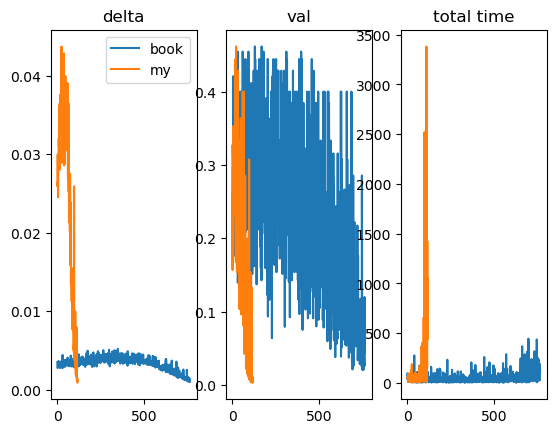

In [27]:
graph = plt.figure()


x = np.arange(len(delta))
g1 = graph.add_subplot(1, 3, 1)
g1.plot(x, delta, label="book")
x = np.arange(len(delta2))
g1.plot(x, delta2, label="my")
g1.set_title("delta")
g1.legend()

x = np.arange(len(val))
g2 = graph.add_subplot(1, 3, 2)
g2.plot(x, val, label="book")
x = np.arange(len(val2))
g2.plot(x, val2, label="my")
g2.set_title("val")

x = np.arange(len(total))
g3 = graph.add_subplot(1, 3, 3)
g3.plot(x, total, label="book")
x = np.arange(len(total2))
g3.plot(x, total2, label="my")
g3.set_title("total time")

plt.savefig("./result/graph2.png")
plt.show()


In [18]:
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state/3))
    return circle

anim = animation.FuncAnimation(fig, animate, frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())